In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../Datasets/diabetes_prediction_dataset.csv')

In [3]:
data['gender'] = data['gender'].astype(str).str.strip().str.upper()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

data['smoking_history'] = data['smoking_history'].apply(recategorize_smoking)

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

X = data.drop('diabetes', axis=1)
y = data['diabetes']

In [ ]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier())])

In [18]:
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [3],
    'classifier__learning_rate': [0.001, 0.01],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8]
}

In [19]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.001, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


Model Accuracy:  0.970566822672907
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       1.00      0.67      0.80      1721

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



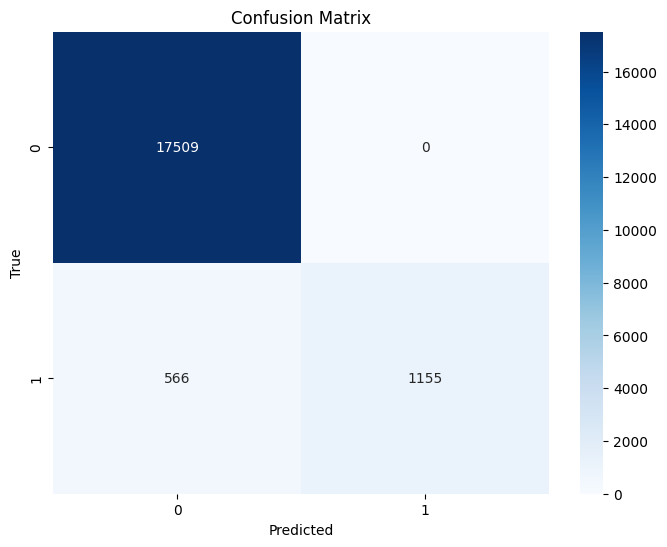

In [13]:
y_pred = grid_search.predict(X_test)

print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()